In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
flight_data_train = pd.read_csv('./flight_data_train_ts.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts.csv')

In [3]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

In [4]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
# flight_data_train['depart_year'] = departdatetime.year
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
# flight_data_test['depart_year'] = departdatetime.year
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [5]:
X_train = flight_data_train.drop(columns=['finalflightstatus', 'delay_in_secs'], axis=1)
X_test = flight_data_test.drop(columns=['finalflightstatus', 'delay_in_secs'], axis=1)

y_train_cls = flight_data_train['finalflightstatus']
y_test_cls = flight_data_test['finalflightstatus']
y_train_reg = flight_data_train['delay_in_secs']
y_test_reg = flight_data_test['delay_in_secs']

In [6]:
y_train_cls = y_train_cls.map({'On-Time': 0, 'Delayed':1})
y_test_cls = y_test_cls.map({'On-Time': 0, 'Delayed':1})

In [7]:
string_columns = X_train.select_dtypes(include=['object', 'string']).columns
string_columns

Index(['flightnumber', 'traffictypecode', 'airlinecode_iata',
       'destination_iata', 'aircraft_iata', 'aircraftparkingposition',
       'publicgatenumber', 'skyc1', 'skyc2'],
      dtype='object')

In [8]:
X_train

,flightnumber,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,aircraftparkingposition,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyc1,skyc2,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute
0,FZ 547,PS,FZ,CMB,7S8,0,E10L,F6,2,86.0,57.2,37.62,120.0,5.0,0.0,29.77,4.97,0,NSC,CAVOK,0.0,0.0,29,4,4,210
1,EK 925,PS,EK,CAI,77W,0,F21,B19,3,98.6,71.6,42.04,60.0,3.0,0.0,29.50,6.21,0,CAVOK,CAVOK,0.0,0.0,11,9,5,1315
2,XY 206,PS,XY,RUH,32N,0,C55R,D11,1,100.4,64.4,31.07,330.0,14.0,0.0,29.53,6.21,0,CAVOK,CAVOK,0.0,0.0,6,6,0,975
3,EK 586,PS,EK,DAC,77W,0,B14,B6,3,75.2,60.8,60.90,240.0,3.0,0.0,30.12,4.97,0,FEW,CAVOK,4500.0,0.0,12,12,6,630
4,EK 532,PS,EK,COK,77W,0,B26L,B32,3,73.4,55.4,53.29,360.0,2.0,0.0,30.03,6.21,0,CAVOK,CAVOK,0.0,0.0,30,1,5,1305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,RA 230,PS,RA,KTM,332,0,E03,F5,2,69.8,62.6,77.90,100.0,10.0,0.0,30.00,4.97,1,BKN,FEW,4500.0,5000.0,1,1,5,265
152636,FZ 8015,PS,FZ,DMM,7M8,0,C30,F8,2,86.0,46.4,25.26,90.0,5.0,0.0,30.03,6.21,0,CAVOK,CAVOK,0.0,0.0,22,11,0,650
152637,EK 857,PS,EK,KWI,77W,0,B18L,B14,3,77.0,51.8,41.42,320.0,4.0,0.0,29.97,6.21,0,CAVOK,CAVOK,0.0,0.0,31,1,0,850
152638,FZ 017,PS,FZ,DOH,7M8,0,C21,F8,2,87.8,59.0,37.90,330.0,9.0,0.0,29.83,6.21,0,CAVOK,CAVOK,0.0,0.0,9,3,2,945


In [9]:
# le = LabelEncoder()
# for col in string_columns:
#     X_train[col] = le.fit_transform(X_train[col])
#     X_test[col] = X_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

In [10]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['flightnumber', 'airlinecode_iata', 
                         'destination_iata', 'aircraft_iata', 'aircraftparkingposition', 
                         'publicgatenumber',]

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train_cls)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

In [11]:
X_train['traffictypecode'].value_counts()

traffictypecode
PS    142944
PE      5076
PC      4620
Name: count, dtype: int64

In [12]:
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal']

ohe = OneHotEncoder(drop='first', sparse_output=False)

encoded = ohe.fit_transform(X_train[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_hot_column))
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



In [13]:
X_train

,flightnumber,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,aircraftparkingposition,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3
0,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,86.0,57.2,37.62,120.0,5.0,0.0,29.77,4.97,0,0.0,0.0,29,4,4,210,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,98.6,71.6,42.04,60.0,3.0,0.0,29.50,6.21,0,0.0,0.0,11,9,5,1315,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,100.4,64.4,31.07,330.0,14.0,0.0,29.53,6.21,0,0.0,0.0,6,6,0,975,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.271960,0.635980,0.271960,0.635980,0,0.271960,0.271960,75.2,60.8,60.90,240.0,3.0,0.0,30.12,4.97,0,4500.0,0.0,12,12,6,630,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.271960,0.757320,0.271960,0.757320,0,0.271960,0.271960,73.4,55.4,53.29,360.0,2.0,0.0,30.03,6.21,0,0.0,0.0,30,1,5,1305,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,0.288783,0.327361,0.360405,0.345247,0,0.336060,0.406511,69.8,62.6,77.90,100.0,10.0,0.0,30.00,4.97,1,4500.0,5000.0,1,1,5,265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152636,0.240394,0.283673,0.172581,0.331339,0,0.369917,0.285672,86.0,46.4,25.26,90.0,5.0,0.0,30.03,6.21,0,0.0,0.0,22,11,0,650,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152637,0.211544,0.224244,0.206318,0.208512,0,0.185037,0.194032,77.0,51.8,41.42,320.0,4.0,0.0,29.97,6.21,0,0.0,0.0,31,1,0,850,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
152638,0.302470,0.283665,0.214357,0.331305,0,0.337736,0.285632,87.8,59.0,37.90,330.0,9.0,0.0,29.83,6.21,0,0.0,0.0,9,3,2,945,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [14]:
numerical_cols = [
    "tmpf",
    "dwpf",
    "relh",
    "drct",
    "sknt",
    "p01i",
    "alti",
    "vsby",
    "skyl1",
    "skyl2",
    # 'depart_day',
    # 'depart_month',
    # 'depart_minute'
]

In [15]:
# scaler = StandardScaler()
# X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [17]:
X_train

,flightnumber,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,aircraftparkingposition,publicgatenumber,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3
0,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,0.515152,0.575,0.343852,0.333333,0.185185,0.0,0.536842,0.799353,0,0.000000,0.0,29,4,4,210,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,0.727273,0.775,0.390344,0.166667,0.111111,0.0,0.252632,1.000000,0,0.000000,0.0,11,9,5,1315,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.271960,0.271960,0.271960,0.271960,0,0.271960,0.271960,0.757576,0.675,0.274955,0.916667,0.518519,0.0,0.284211,1.000000,0,0.000000,0.0,6,6,0,975,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.271960,0.635980,0.271960,0.635980,0,0.271960,0.271960,0.333333,0.625,0.588724,0.666667,0.111111,0.0,0.905263,0.799353,0,0.642857,0.0,12,12,6,630,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.271960,0.757320,0.271960,0.757320,0,0.271960,0.271960,0.303030,0.550,0.508678,1.000000,0.074074,0.0,0.810526,1.000000,0,0.000000,0.0,30,1,5,1305,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152635,0.288783,0.327361,0.360405,0.345247,0,0.336060,0.406511,0.242424,0.650,0.767540,0.277778,0.370370,0.0,0.778947,0.799353,1,0.642857,1.0,1,1,5,265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152636,0.240394,0.283673,0.172581,0.331339,0,0.369917,0.285672,0.515152,0.425,0.213842,0.250000,0.185185,0.0,0.810526,1.000000,0,0.000000,0.0,22,11,0,650,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
152637,0.211544,0.224244,0.206318,0.208512,0,0.185037,0.194032,0.363636,0.500,0.383822,0.888889,0.148148,0.0,0.747368,1.000000,0,0.000000,0.0,31,1,0,850,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
152638,0.302470,0.283665,0.214357,0.331305,0,0.337736,0.285632,0.545455,0.600,0.346797,0.916667,0.333333,0.0,0.600000,1.000000,0,0.000000,0.0,9,3,2,945,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [18]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original cyclic features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [19]:
columns_to_drop = [ 
    "flightnumber",
    # "airlinecode_iata",
    # "destination_iata",
    "aircraftparkingposition",
    "publicgatenumber",
]
X_train.drop(
    columns=columns_to_drop,
    axis=1,
    inplace=True,
)
X_test.drop(
    columns=columns_to_drop,
    axis=1,
    inplace=True,
)

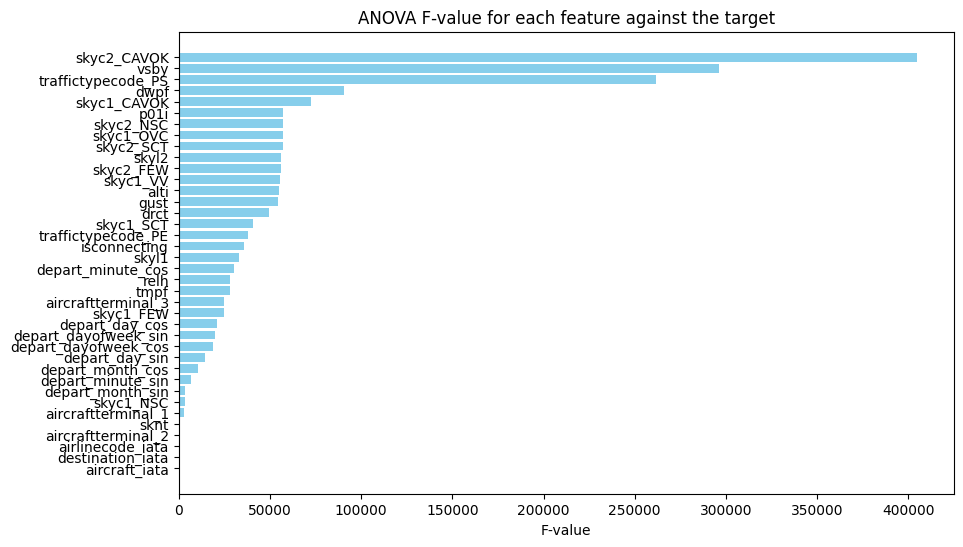

In [20]:
from scipy.stats import f_oneway

# Assuming y_train_cls is your target variable
anova_results = {}
for column in X_train.columns:
    # Perform ANOVA
    f_val, p_val = f_oneway(X_train[column], y_train_cls)
    anova_results[column] = f_val

# Sort the results by F-value
sorted_anova = sorted(anova_results.items(), key=lambda x: x[1], reverse=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_anova], [x[1] for x in sorted_anova], color='skyblue')
plt.xlabel('F-value')
plt.title('ANOVA F-value for each feature against the target')
plt.gca().invert_yaxis()
plt.show()

In [21]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# def print_metrics(y_test, y_pred):
#     # Accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Accuracy: {accuracy:.2f}")
    
#     # Precision (weighted for multi-class)
#     precision = precision_score(y_test, y_pred)
#     print(f"Precision: {precision:.2f}")
    
#     # Recall (weighted for multi-class)
#     recall = recall_score(y_test, y_pred)
#     print(f"Recall: {recall:.2f}")
    
#     # F1 Score (weighted for multi-class)
#     f1 = f1_score(y_test, y_pred)
#     print(f"F1 Score: {f1:.2f}")

In [22]:
# rf_cls = RandomForestClassifier(n_estimators=100, max_depth=20)
# print('Original dataset shape %s' % Counter(y_train_cls))

# sm = SMOTE(random_state=42)
# X_balanced, y_balanced = sm.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_balanced))

# rf_cls.fit(X_balanced, y_balanced)

# y_pred_cls = rf_cls.predict(X_test)
# print_metrics(y_test_cls, y_pred_cls)

In [23]:
# print_metrics(y_test_cls, y_pred_cls)

In [24]:
# # Get feature importance from random forest
# importances = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf_cls.feature_importances_
# })
# importances = importances.sort_values('importance', ascending=False)

# # Plot feature importances
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(importances)), importances['importance'])
# plt.xticks(range(len(importances)), importances['feature'], rotation=45, ha='right')
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Random Forest Feature Importance')
# plt.tight_layout()
# plt.show()


In [25]:
from imblearn.over_sampling import SMOTE




Original dataset shape Counter({0: 111128, 1: 41512})
Resampled dataset shape Counter({0: 111128, 1: 111128})


In [26]:
X_full = pd.concat([X_train, X_test], axis=0)
X_full

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyl1,skyl2,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,depart_month_sin,depart_month_cos,depart_day_sin,depart_day_cos,depart_dayofweek_sin,depart_dayofweek_cos,depart_minute_sin,depart_minute_cos
0,0.271960,0.271960,0.271960,0,0.515152,0.575,0.343852,0.333333,0.185185,0.0,0.536842,0.799353,0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,8.660254e-01,-5.000000e-01,-0.394356,0.918958,-0.433884,-0.900969,0.793353,0.608761
1,0.271960,0.271960,0.271960,0,0.727273,0.775,0.390344,0.166667,0.111111,0.0,0.252632,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.000000e+00,-1.836970e-16,0.790776,-0.612106,-0.974928,-0.222521,-0.518773,0.854912
2,0.271960,0.271960,0.271960,0,0.757576,0.675,0.274955,0.916667,0.518519,0.0,0.284211,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.224647e-16,-1.000000e+00,0.937752,0.347305,0.000000,1.000000,-0.896873,-0.442289
3,0.635980,0.271960,0.635980,0,0.333333,0.625,0.588724,0.666667,0.111111,0.0,0.905263,0.799353,0,0.642857,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-2.449294e-16,1.000000e+00,0.651372,-0.758758,-0.781831,0.623490,0.382683,-0.923880
4,0.757320,0.271960,0.757320,0,0.303030,0.550,0.508678,1.000000,0.074074,0.0,0.810526,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.000000e-01,8.660254e-01,-0.201299,0.979530,-0.974928,-0.222521,-0.555570,0.831470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38156,0.283685,0.252870,0.270438,0,0.030303,0.400,0.607552,0.472222,0.074074,0.0,0.905263,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.000000e-01,8.660254e-01,0.485302,-0.874347,0.974928,-0.222521,0.831470,-0.555570
38157,0.280895,0.181803,0.264555,0,0.424242,0.525,0.361523,0.027778,0.296296,0.0,0.684211,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.660254e-01,5.000000e-01,-0.651372,-0.758758,-0.974928,-0.222521,-0.960050,-0.279829
38158,0.224240,0.417168,0.178402,0,0.333333,0.575,0.511413,0.444444,0.259259,0.0,0.936842,1.000000,0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-5.000000e-01,8.660254e-01,-0.724793,0.688967,-0.433884,-0.900969,0.625923,-0.779884
38159,0.283685,0.199857,0.309222,0,0.393939,0.750,0.725991,0.916667,0.333333,0.0,0.778947,1.000000,0,0.357143,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-2.449294e-16,1.000000e+00,0.571268,0.820763,0.433884,-0.900969,-0.965926,0.258819


In [27]:
# neighbors = NearestNeighbors(n_neighbors=39*2)
# neighbors_fit = neighbors.fit(X_train)
# distances, indices = neighbors_fit.kneighbors(X_train)
# avg_distance = distances.mean(axis=1)
# plt.plot(np.sort(avg_distance))
# plt.show()

In [28]:
# sc = DBSCAN(eps=1, min_samples=39*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_full), columns=['Cluster'])
# clusters['Cluster'].value_counts()

In [29]:
hdbscan_model = HDBSCAN(
    min_cluster_size=1000,      # Increase to avoid microclusters
    min_samples=5,              # Lower to reduce noise points
    cluster_selection_epsilon=0.6,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

In [30]:
from hdbscan import approximate_predict
clusters_test, _ = approximate_predict(hdbscan_model, X_test)

In [31]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test

: 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

rf_models = {}
metrics = {}
all_y_true = []
all_y_pred = []
model_weights = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue

    # Subset the training and test data for the cluster
    X_train_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_train_cls_cluster = y_train_cls.loc[X_train_cluster.index]
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cls_cluster = y_test_cls.loc[X_test_cluster.index]
    
    smote = SMOTE(random_state=42)
    print('Original dataset shape %s' % Counter(y_train_cls_cluster))
    X_train_cluster, y_train_cls_cluster = smote.fit_resample(X_train_cluster, y_train_cls_cluster)
    print('Resampled dataset shape %s' % Counter(y_train_cls_cluster))

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss'])
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=50,
        cv=3,
        n_jobs=-1,
        scoring='f1'
    )
    bayes_cv.fit(X_train_cluster, y_train_cls_cluster)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf

    # Make predictions and evaluate metrics
    y_pred = best_rf.predict(X_test_cluster)
    accuracy = accuracy_score(y_test_cls_cluster, y_pred)
    precision = precision_score(y_test_cls_cluster, y_pred)
    recall = recall_score(y_test_cls_cluster, y_pred)
    f1 = f1_score(y_test_cls_cluster, y_pred)
    metrics[cluster] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1}
    
    # Collect predictions for overall metric
    all_y_true.extend(y_test_cls_cluster)
    all_y_pred.extend(y_pred)
    
    # Print metrics
    print(f"Cluster {cluster} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_test_cls_cluster, y_pred))

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 0 Metrics:
Accuracy: 0.6576862123613312
Precision: 0.5450236966824644
Recall: 0.48936170212765956
F1 Score: 0.515695067264574
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       396
           1       0.55      0.49      0.52       235

    accuracy                           0.66       631
   macro avg       0.63      0.62      0.63       631
weighted avg       0.65      0.66      0.65       631

Cluster 1 Metrics:
Accuracy: 0.696969696969697
Precision: 0.24444444444444444
Recall: 0.23404255319148937
F1 Score: 0.2391304347826087
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       184
           1       0.24      0.23      0.24        47

    accuracy                           0.70       231
   macro avg       0.53      0.52      0.52       231
weighted avg       0.69      0.70      0.69       231

Cluster 2 Metrics:
Accuracy: 0.7575757575757576
Precision: 0.3529411764705882

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print("\nSummary of metrics for each cluster:")
for cluster, metric in metrics.items():
    print(f"Cluster {cluster}: Accuracy = {metric['accuracy']}, Precision = {metric['precision']}, Recall = {metric['recall']}, F1 Score = {metric['f1_score']}")



In [67]:
# Overall metrics
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
overall_precision = precision_score(all_y_true, all_y_pred)
overall_recall = recall_score(all_y_true, all_y_pred)
overall_f1 = f1_score(all_y_true, all_y_pred)
print("\nOverall Metrics:")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics:
Overall Accuracy: 0.7542936851588155
Overall Precision: 0.5888860303576022
Overall Recall: 0.2502733435381588
Overall F1 Score: 0.3512621806184301
